In [25]:
import os
import sys
import math
from copy import deepcopy

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn 
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

use_cuda = False
os.environ["CUDA_VISIBLE_DEVICES"]="7"
if torch.cuda.is_available():
    device = torch.cuda.device("cuda:7")
    use_cuda = True

In [26]:
sys.path.insert(0, 'utils/')
from MyUtils import *
from MyDatasets import *

In [27]:
dataset_LMR_train = LMDRDataset(train=True, emb_size=300)
dataset_LMR_test = LMDRDataset(train=False, emb_size=300)

In [28]:
dataset_LMR_kaggle = LMDRDataset(kaggle=True, emb_size=300)

In [29]:
dataloader_LMR_train = DataLoader(dataset_LMR_train, batch_size=128, shuffle=True)
dataloader_LMR_test = DataLoader(dataset_LMR_test, batch_size=128, shuffle=True)

In [30]:
class NLPClassifier(nn.Module):
    def __init__(self, in_size):
        super(NLPClassifier, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(in_size, 200),
            nn.Tanh(),
            nn.Linear(200, 100),
            nn.Tanh(),
            nn.Linear(100, 1)
        )
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.linear(x).view(-1)

In [31]:
class NLPClassifier_WITH_EXP(nn.Module):
    def __init__(self, in_size):
        super(NLPClassifier_WITH_EXP, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(in_size, 200),
            nn.Tanh(),
            nn.Linear(200, 100),
            nn.Tanh(),
            nn.Linear(100, 1)
        )
        self.explinear = ExpLinear(in_size)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.linear(x).view(-1) + self.explinear(x).view(-1)
    
    # get parameter alpha from explinear block
    def get_alpha(self):
        return self.explinear.get_alpha()

Epoch 199... Empirical Loss/Misclassification Rate (Train): 55.212/2354.000	 Empirical Loss/Misclassification Rate (Test): 70.643/1259.000

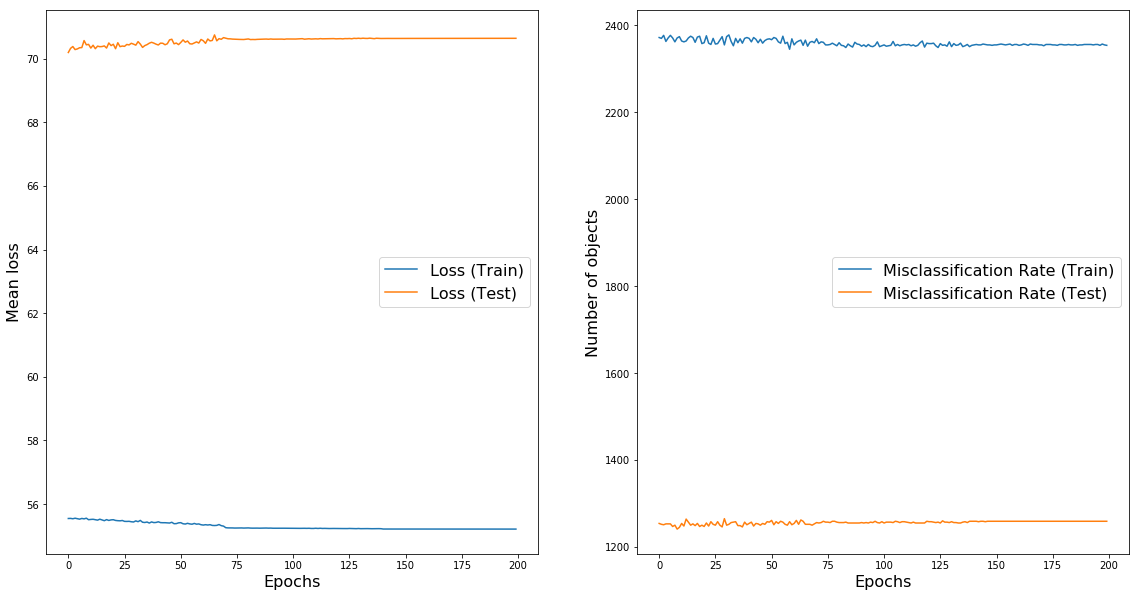

In [42]:
net_LMR_fc = NLPClassifier(300)
if use_cuda:
    net_LMR_fc = net_LMR_fc.cuda()

train_(network=net_LMR_fc, loss_func=loss_func,
       learning_rate=0.00005, reinit_optim=70,
       train_strategy=train_strategy_STOCH, test_strategy=test_strategy_STOCH,
       reg_lambda=None,
       epochs=200,
       dataloader_train=dataloader_LMR_train, dataloader_test=dataloader_LMR_test,
       )

Epoch 69... Empirical Loss/Misclassification Rate (Train): 57.049/2434.000	 Empirical Loss/Misclassification Rate (Test): 69.438/1239.000

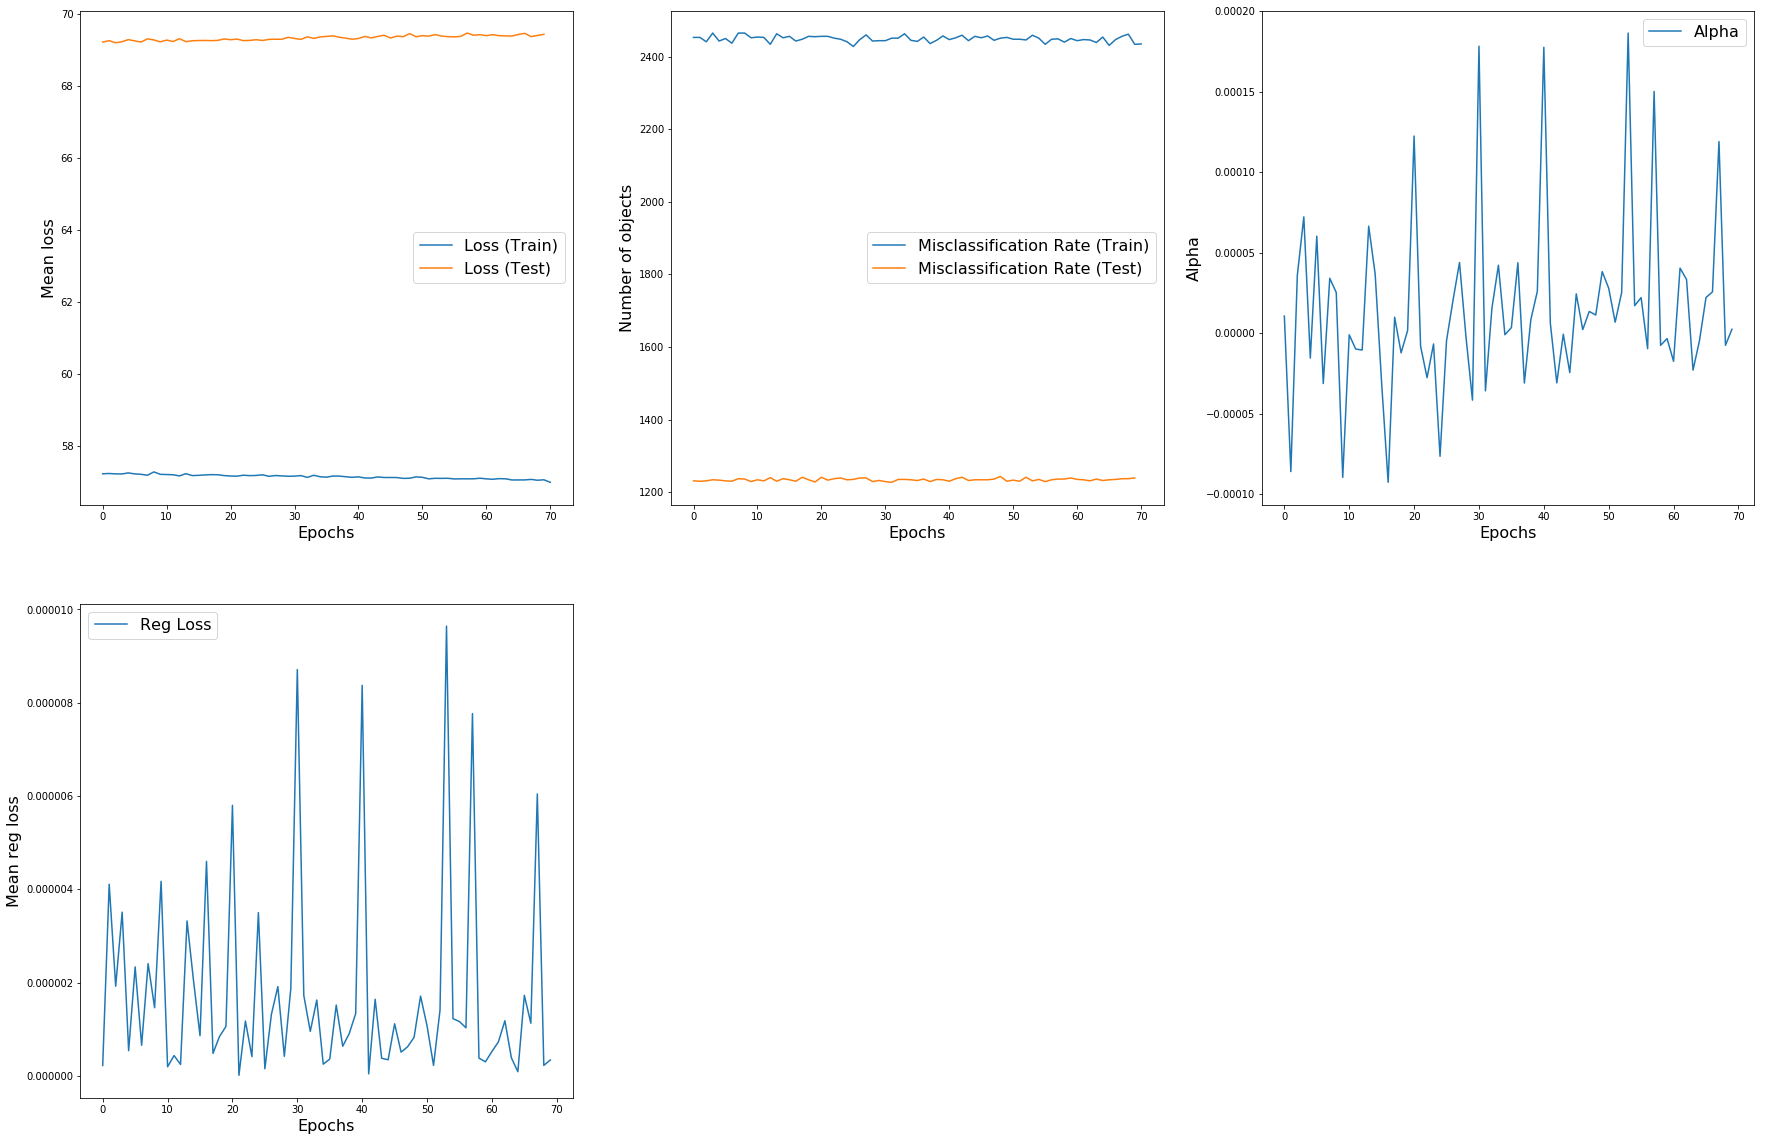

In [36]:
net_LMR_fc_e = NLPClassifier_WITH_EXP(300)
if use_cuda:
    net_LMR_fc_e = net_LMR_fc_e.cuda()
net_LMR_fc_e.explinear.init_weigth(0, 0.001)

train_EXP(network=net_LMR_fc_e, loss_func=loss_func_EXP,
          learning_rate=0.00005, reinit_optim=70,
          train_strategy=train_strategy_STOCH, test_strategy=test_strategy_STOCH,
          reg_lambda=0.05,
          epochs=200,
          dataloader_train=dataloader_LMR_train, dataloader_test=dataloader_LMR_test,
         )

In [37]:
(1 - 2434.000 / dataset_LMR_train.__len__())

0.8609142857142857

In [38]:
(1 - 1239.000 / dataset_LMR_test.__len__())

0.8348

In [39]:
pred_shuffled = (net_LMR_fc_e(dataset_LMR_kaggle.embeddings.cuda()) > 0).float() * 2 - 1

In [40]:
pred = torch.zeros_like(pred_shuffled)
for idx, name in enumerate(dataset_LMR_kaggle.file_names):
    id_ = int(name[:name.find('.')])
    pred[id_] = pred_shuffled[idx]

In [41]:
import csv
with open('test_subm.csv', 'w') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(['id', 'labels'])
    for id_, res in enumerate(pred):
        spamwriter.writerow([id_, int(res) if int(res) == 1 else 0])